## **Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('MarketPricePrediction.csv', index_col = 'date', parse_dates = True)

df.head()
print(df.info())
df.index.isna().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10227 entries, 2005-01-01 to 2015-12-01
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
dtypes: int64(5), object(4)
memory usage: 799.0+ KB
None


<ipython-input-1-e3fa63a17d04>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('MarketPricePrediction.csv', index_col = 'date', parse_dates = True)


0

In [2]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2005-01-01,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR
2006-01-01,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR
2010-01-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR
2011-01-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR
2012-01-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR


## **Exploratory Data Analysis (EDA)**

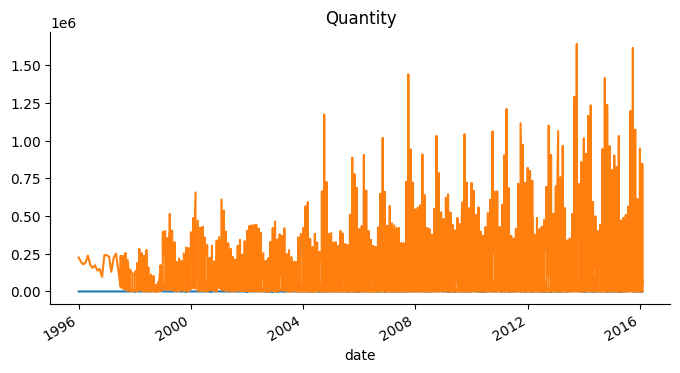

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting the time series

# Price Mode Graph
df['priceMod'].plot(kind='line', figsize=(8, 4), title='Price Mode')
plt.gca().spines[['top', 'right']].set_visible(False)

# Quantity Graph
df['quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

## **Feature Engeneering**

In [4]:
for lag in range(1, 13):
  df[f'lag_{lag}'] = df['priceMod'].shift(lag)
  df[f'lag_{lag}'] = df['quantity'].shift(lag)

# Creating rolling statistics
df['rolling_mean'] = df['priceMod'].rolling(window = 12).mean()
df['rolling_mean'] = df['quantity'].rolling(window = 12).mean()

df['rolling_std'] = df['priceMod'].rolling(window = 12).std()
df['rolling_std'] = df['quantity'].rolling(window = 12).std()

df.dropna(inplace = True)

print(df.head())

                market     month  year  quantity  priceMin  priceMax  \
date                                                                   
2012-02-01  ABOHAR(PB)  February  2012       675       510       650   
2013-02-01  ABOHAR(PB)  February  2013       845      1400      1843   
2014-02-01  ABOHAR(PB)  February  2014      1115       831      1163   
2015-02-01  ABOHAR(PB)  February  2015      1115      1200      1946   
2005-03-01  ABOHAR(PB)     March  2005       900       281       357   

            priceMod state    city   lag_1  ...   lag_5   lag_6   lag_7  \
date                                        ...                           
2012-02-01       570    PB  ABOHAR   300.0  ...  1305.0   440.0   675.0   
2013-02-01      1629    PB  ABOHAR   675.0  ...  1400.0  1305.0   440.0   
2014-02-01       983    PB  ABOHAR   845.0  ...  1800.0  1400.0  1305.0   
2015-02-01      1688    PB  ABOHAR  1115.0  ...   555.0  1800.0  1400.0   
2005-03-01       322    PB  ABOHAR  1115.0  .

## **Model Selection and training**

**ARIMA**

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA Model
arima_model = ARIMA(df['priceMod'], order = (5, 1, 0))
arima_model_quant = ARIMA(df['quantity'], order = (5, 1, 0))

arima_result = arima_model.fit()
arima_result_quant = arima_model_quant.fit()

print(arima_result.summary())
print(arima_result_quant.summary())

print("****************************************************")
# Forecast
steps = 12
arima_forecast = arima_result.forecast(steps = steps)
arima_forecast_quant = arima_result_quant.forecast(steps = steps)

print(arima_forecast)
print(arima_forecast_quant)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:               priceMod   No. Observations:                10215
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -82031.424
Date:                Thu, 30 May 2024   AIC                         164074.848
Time:                        15:28:55   BIC                         164118.237
Sample:                             0   HQIC                        164089.520
                              - 10215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6633      0.008    -84.193      0.000      -0.679      -0.648
ar.L2         -0.2474      0.009    -28.577      0.000      -0.264      -0.230
ar.L3         -0.3089      0.009    -33.857      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


**Prophet**

In [13]:

from prophet import Prophet

# Prepare data for Prophet
df_prophet = df.reset_index()[['date', 'priceMod']].rename(columns = {'date': 'ds', 'priceMod': 'y'})
df_prophet_quant = df.reset_index()[['date', 'quantity']].rename(columns = {'date': 'ds', 'quantity': 'y'})


# Fit Prophet model
prophet_model = Prophet()
prophet_model_quant = Prophet()

prophet_model.fit(df_prophet)
prophet_model_quant.fit(df_prophet_quant)

# Forecast
future = prophet_model.make_future_dataframe(periods = 12, freq = 'M')
future_quant = prophet_model_quant.make_future_dataframe(periods = 12, freq = 'M')

prophet_forecast = prophet_model.predict(future)
prophet_forecast_quant = prophet_model.predict(future_quant)

print("\n******************************************************\n_____________________Price Mode______________________")
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print("\n******************************************************\n_____________________Quantity________________________")
print(prophet_forecast_quant[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwr5ewln/yjjc_tqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdwr5ewln/ugzz0kh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18562', 'data', 'file=/tmp/tmpdwr5ewln/yjjc_tqt.json', 'init=/tmp/tmpdwr5ewln/ugzz0kh_.json', 'output', 'file=/tmp/tmpdwr5ewln/prophet_modelp2f7ad9t/prophet_model-20240530153413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit


******************************************************
_____________________Price Mode______________________
            ds         yhat   yhat_lower   yhat_upper
249 2016-09-30  2204.625591  1506.693542  2928.746729
250 2016-10-31  1894.748592  1204.139992  2563.812300
251 2016-11-30  1796.993561  1115.230377  2552.326405
252 2016-12-31  1808.393780  1066.164710  2552.253232
253 2017-01-31  1697.786788   945.922882  2381.807932

******************************************************
_____________________Quantity________________________
            ds         yhat   yhat_lower   yhat_upper
249 2016-09-30  2204.625591  1462.226255  2894.020545
250 2016-10-31  1894.748592  1145.440555  2665.125343
251 2016-11-30  1796.993561  1080.048627  2496.972428
252 2016-12-31  1808.393780  1061.314847  2521.925839
253 2017-01-31  1697.786788   983.535677  2452.901270


**LSTM**

In [19]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Scaling data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['priceMod'].values.reshape(-1, 1))
scaled_data_quant = scaler.fit_transform(df['quantity'].values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X_p, Y_p = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X_p.append(a)
        Y_p.append(data[i + time_step, 0])
    return np.array(X_p), np.array(Y_p)

def create_dataset_quant(data, time_step=1):
    X_q, Y_q = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X_q.append(a)
        Y_q.append(data[i + time_step, 0])
    return np.array(X_q), np.array(Y_q)


time_step = 12
X_p, Y_p = create_dataset(scaled_data, time_step)
X_q, Y_q = create_dataset_quant(scaled_data_quant, time_step)
X_p = X_p.reshape(X_p.shape[0], X_p.shape[1], 1)
X_q = X_q.reshape(X_q.shape[0], X_q.shape[1], 1)

# Split data into train and test
train_size = int(len(X_p) * 0.8)
train_size_quant = int(len(X_q) * 0.8)

test_size = len(X_p) - train_size
test_size_quant = len(X_q) - train_size_quant

X_p_train, X_p_test = X_p[0:train_size], X_p[train_size:len(X_p)]
X_q_train, X_q_test = X_q[0:train_size_quant], X_q[train_size_quant:len(X_q)]

Y_p_train, Y_p_test = Y_p[0:train_size], Y_p[train_size:len(Y_p)]
Y_q_train, Y_q_test = Y_q[0:train_size_quant], Y_q[train_size_quant:len(Y_q)]

# LSTM model
model = tf.keras.Sequential()
model_quant = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_quant.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)))

model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model_quant.add(tf.keras.layers.LSTM(50, return_sequences=False))

model.add(tf.keras.layers.Dense(25))
model_quant.add(tf.keras.layers.Dense(25))

model.add(tf.keras.layers.Dense(1))
model_quant.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_quant.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Train the model
model.fit(X_p_train, Y_p_train, batch_size = 1, epochs = 1)
model_quant.fit(X_q_train, Y_q_train, batch_size = 1, epochs = 1)

# Predicting
train_predict = model.predict(X_p_train)
train_predict_quant = model_quant.predict(X_q_train)

test_predict = model.predict(X_p_test)
test_predict_quant = model_quant.predict(X_q_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
train_predict_quant = scaler.inverse_transform(train_predict_quant)

test_predict = scaler.inverse_transform(test_predict)
test_predict_quant = scaler.inverse_transform(test_predict_quant)


64/64 [==============================] - 0s 5ms/step


## **Model Evaluation**

**ARIMA Evaluation**

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ARIMA evaluation
actual_values = df['priceMod'][-steps:]
actual_values_quant = df['quantity'][-steps:]

print("Length of actual values: ", len(actual_values))
print("Length of forecast values: ", len(arima_forecast))

arima_mae = mean_absolute_error(actual_values, arima_forecast)
arima_mae_quant = mean_absolute_error(actual_values_quant, arima_forecast_quant)

arima_mse = mean_squared_error(actual_values, arima_forecast)
arima_mse_quant = mean_squared_error(actual_values_quant, arima_forecast_quant)

arima_rmse = np.sqrt(arima_mse)
arima_rmse_quant = np.sqrt(arima_mse_quant)

print("________________________\n_____Price Mode______\nARIMA MAE: ", arima_mae, "\nARIMA MSE: ", arima_mse, "\nARIMA RMSE: ", arima_rmse, "\n")
print("________________________\n_____Quantity________\nARIMA MAE: ", arima_mae_quant, "\nARIMA MSE: ", arima_mse_quant, "\nARIMA RMSE: ", arima_rmse_quant)



Length of actual values:  12
Length of forecast values:  12
________________________
_____Price Mode______
ARIMA MAE:  425.6774237339948 
ARIMA MSE:  281013.9032251841 
ARIMA RMSE:  530.1074449818491 

________________________
_____Quantity________
ARIMA MAE:  60765.46458678812 
ARIMA MSE:  5618379564.480217 
ARIMA RMSE:  74955.85076883736


**Prophet Evaluation**

In [24]:
# Prophet Evaluation
prophet_mae = mean_absolute_error(df['priceMod'][-12:], prophet_forecast['yhat'][-12:])
prophet_mae_quant = mean_absolute_error(df['quantity'][-12:], prophet_forecast['yhat'][-12:])

prophet_mse = mean_squared_error(df['priceMod'][-12:], prophet_forecast['yhat'][-12:])
prophet_mse_quant = mean_squared_error(df['quantity'][-12:], prophet_forecast['yhat'][-12:])

prophet_rmse = np.sqrt(prophet_mse)
prophet_rmse_quant = np.sqrt(prophet_mse_quant)


print("_________________\n_____Price Mode_____\nProphet MAE: ", prophet_mae, "\nProphet MSE: ", prophet_mse, "\nProphet RMSE: ", prophet_rmse, "\n")
print("_________________\n_____Quantity_______\nProphet MAE: ", prophet_mae_quant, "\nProphet MSE: ", prophet_mse_quant, "\nProphet RMSE: ", prophet_rmse_quant)



_________________
_____Price Mode_____
Prophet MAE:  906.5442211721092 
Prophet MSE:  959086.7227767608 
Prophet RMSE:  979.3297313860949 

_________________
_____Quantity_______
Prophet MAE:  150045.2057788279 
Prophet MSE:  25872612600.986706 
Prophet RMSE:  160849.6583800746


**LSTM Evaluation**

In [25]:
# LSTM Evaluation
lstm_mae = mean_absolute_error(Y_p_test, test_predict)
lstm_mae_quant = mean_absolute_error(Y_q_test, test_predict_quant)

lstm_mse = mean_squared_error(Y_p_test, test_predict)
lstm_mse_quant = mean_squared_error(Y_q_test, test_predict_quant)

lstm_rmse = np.sqrt(lstm_mse)
lstm_rmse_quant = np.sqrt(lstm_mse_quant)

print("_________________\n____Price Mode____\nLSTM MAE: ", lstm_mae, "\nLSTM MSE: ", lstm_mse, "\nLSTM RMSE: ", lstm_rmse, "\n")
print("_________________\n____Quantity______\nLSTM MAE: ", lstm_mae_quant, "\nLSTM MSE: ", lstm_mse_quant, "\nLSTM RMSE: ", lstm_rmse_quant)


_________________
____Price Mode____
LSTM MAE:  206657.2156973063 
LSTM MSE:  50695773743.09283 
LSTM RMSE:  225157.22005543776 

_________________
____Quantity______
LSTM MAE:  83175.83765239497 
LSTM MSE:  12574158892.220556 
LSTM RMSE:  112134.55708308905


## **Tuning and Validation**

In [28]:
# Since it is computationally expensive to use the whole grid
# p = (0, 1, 2, 3), d = 1, q = (0, 1, 2, 3)
# Since the dataset is large, we get a subset of it of 1000 obs
!pip install pmdarima
from pmdarima import auto_arima
subset_df = df['priceMod'].iloc[:1000]
auto_arima_model = auto_arima(subset_df, start_p = 2, start_q = 0,
                              max_p = 5, max_q = 2, seasonal = True, m = 12,
                              d = 1, D = 1, trace = True,
                              suppress_warnings = True, stepwise = True)
print(auto_arima_model.summary())

subset_df_quant = df['quantity'].iloc[:1000]
auto_arima_model_quant = auto_arima(subset_df_quant, start_p = 0, start_q = 0,
                              max_p = 2, max_q = 2, seasonal = True, m = 12,
                              d = 1, D = 1, trace = True,
                              suppress_warnings = True, stepwise = True)
print("********** QUANTITY************\n")
print(auto_arima_model_quant.summary())

# Using the whole dataset with the best (p, d, q)
best_params = auto_arima_model.order
best_params_quant = auto_arima_model_quant.order

best_arima_model = ARIMA(df['priceMod'], order = best_params)
best_arima_model_quant = ARIMA(df['quantity'], order = best_params_quant)

best_arima_result = best_arima_model.fit()
print(best_arima_result.summary())

best_arima_result_quant = best_arima_model_quant.fit()
print("Quantity_____\n", best_arima_result_quant.summary)

best_arima_forecast = best_arima_result.forecast(steps = 12)
print(best_arima_forecast)

best_arima_forecast_quant = best_arima_result_quant.forecast(steps = 12)
print("Quantity_____\n", best_arima_forecast_quant)

# Evaluating the best ARIMA model
best_arima_mae = mean_absolute_error(df['priceMod'][-12:], best_arima_forecast)
best_arima_mae_quant = mean_absolute_error(df['quantity'][-12:], best_arima_forecast_quant)

best_arima_mse = mean_squared_error(df['priceMod'][-12:], best_arima_forecast)
best_arima_mse_quant = mean_squared_error(df['quantity'][-12:], best_arima_forecast_quant)

best_arima_rmse = np.sqrt(best_arima_mse)
best_arima_rmse_quant = np.sqrt(best_arima_mse_quant)

print("***********************************")
print("____________________\n______Price Mode_____\nBest ARIMA MAE: ", best_arima_mae, "\nBest ARIMA MSE: ", best_arima_mse, "\nBest ARIMA RMSE: ", best_arima_rmse, "\n")
print("____________________\n______Quantity_______\nBest ARIMA MAE: ", best_arima_mae_quant, "\nBest ARIMA MSE: ", best_arima_mse_quant, "\nBest ARIMA RMSE: ", best_arima_rmse_quant)



Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=6.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16991.924, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=16305.413, Time=2.89 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=16587.065, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16201.397, Time=5.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=13.35 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=16479.649, Time=2.43 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=16186.241, Time=8.48 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=16276.834, Time=4.63 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=15.82 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=16152.622, Time=8.25 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=16241.519, Time=5.45 sec
 ARIMA(3,1,0)(2,1,1)[12]         

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:               priceMod   No. Observations:                10215
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -81505.838
Date:                Thu, 30 May 2024   AIC                         163025.676
Time:                        16:18:17   BIC                         163076.296
Sample:                             0   HQIC                        163042.792
                              - 10215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1237      0.010     12.309      0.000       0.104       0.143
ar.L2          0.2456      0.009     28.303      0.000       0.229       0.263
ar.L3         -0.1527      0.010    -15.862      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
